In [1]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
pd.set_option('display.max_rows', 100)

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import seaborn as sns

from utils import *

import sys
sys.path.append("../")

# Shows files

In [2]:
config_names = [
   "MESSI",
   "MESSI+\nSFA+ED+\nSIMD",
   "MESSI+\nSFA+EW+\nSIMD"
]

        
path = "logs/MESSI_SFA_logs_knn"
all_files = read_logs(log_type="query", path=path, config_names = config_names)

Config logs/MESSI_SFA_logs_knn/ASTRO/10
Config logs/MESSI_SFA_logs_knn/ASTRO/3
Config logs/MESSI_SFA_logs_knn/ASTRO/5
-----------------
Config logs/MESSI_SFA_logs_knn/BIGANN/10
Config logs/MESSI_SFA_logs_knn/BIGANN/3
Config logs/MESSI_SFA_logs_knn/BIGANN/5
-----------------
Config logs/MESSI_SFA_logs_knn/DEEP1b/10
Config logs/MESSI_SFA_logs_knn/DEEP1b/3
Config logs/MESSI_SFA_logs_knn/DEEP1b/5
-----------------
Config logs/MESSI_SFA_logs_knn/ETHC/10
Config logs/MESSI_SFA_logs_knn/ETHC/3
Config logs/MESSI_SFA_logs_knn/ETHC/5
-----------------
Config logs/MESSI_SFA_logs_knn/ISC_EHB_DepthPhases/10
Config logs/MESSI_SFA_logs_knn/ISC_EHB_DepthPhases/3
Config logs/MESSI_SFA_logs_knn/ISC_EHB_DepthPhases/5
-----------------
Config logs/MESSI_SFA_logs_knn/Iquique/10
Config logs/MESSI_SFA_logs_knn/Iquique/3
Config logs/MESSI_SFA_logs_knn/Iquique/5
-----------------
Config logs/MESSI_SFA_logs_knn/Meier2019JGR/10
Config logs/MESSI_SFA_logs_knn/Meier2019JGR/3
Config logs/MESSI_SFA_logs_knn/Meier2019

In [3]:
query_times = pd.DataFrame(columns=["method", "querying time", "config", "dataset"])

i = 0
for ds_name, files in all_files.items():
    df_all = pd.DataFrame()
    # print (file.split("/")[2])
    for name, file in files.items():

        # display(df.head())
        df = pd.read_csv(file).iloc[:-1]  # last entry is the average        
        df["querying time"] = df["querying time"] / 1_000_000        
        df["method"] = name
        df["config"] = np.int32(file.split("/")[3])
        df["dataset"] = file.split("/")[2]

        query_times = pd.concat([query_times, df[["method", "querying time", "config", "dataset"]]], ignore_index=True)
        i = i+1        
        
np.unique(query_times.dataset)

array(['ASTRO', 'BIGANN', 'DEEP1b', 'ETHC', 'ISC_EHB_DepthPhases',
       'Iquique', 'Meier2019JGR', 'NEIC', 'OBS', 'OBST2024', 'PNW',
       'SALD', 'SCEDC', 'SIFT1b', 'STEAD', 'TXED'], dtype=object)

In [4]:
subset = query_times.rename(columns={
    "config":"kNNs", "dataset": "Dataset", "method": "Method",
    "querying time" : "query time in s"})
subset = subset[query_times.method.isin([ "MESSI", "MESSI+\nSFA+ED+\nSIMD", "MESSI+\nSFA+EW+\nSIMD"])]


subset.Method.replace("MESSI+\nSFA+ED+\nSIMD", "SOFA + ED", inplace=True)
subset.Method.replace("MESSI+\nSFA+EW+\nSIMD", "SOFA + EW", inplace=True)

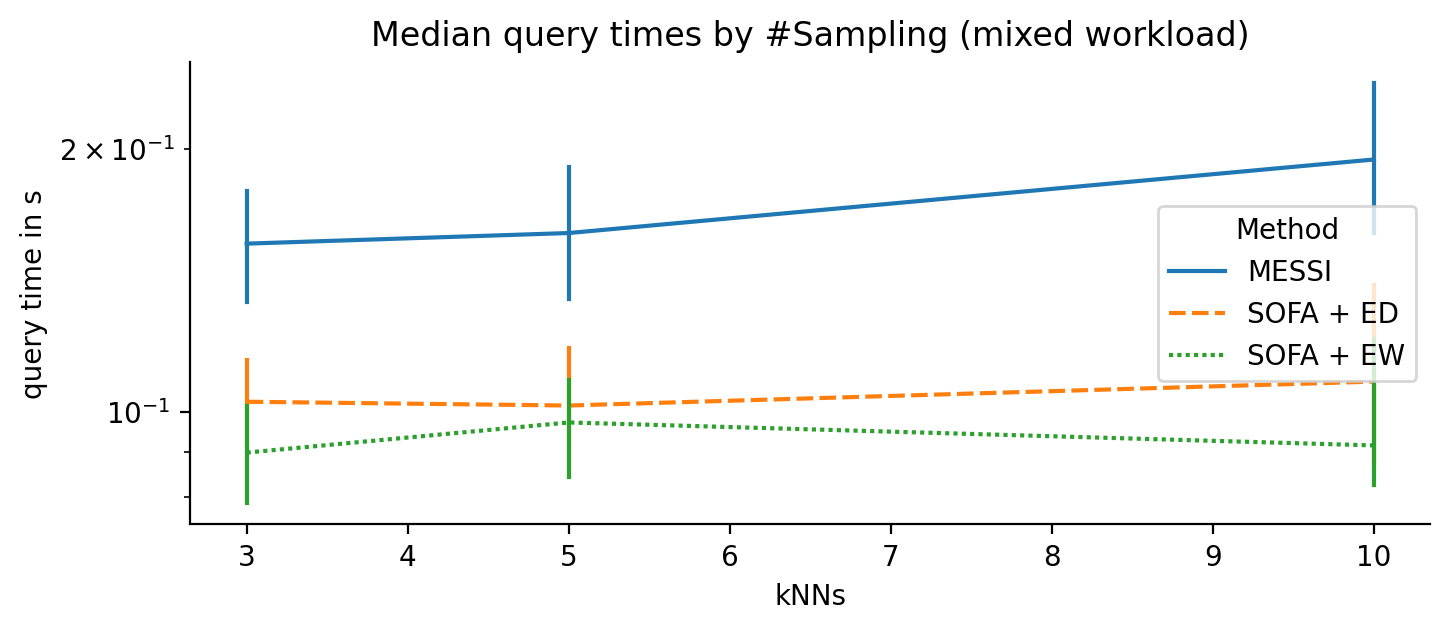

In [5]:
fig, ax = plt.subplots(figsize=(8,3))
sns.lineplot(x="kNNs", y="query time in s", hue="Method", estimator=np.median,  err_style="bars", 
             style="Method", data=subset, ax = ax, errorbar=('ci', 99))
ax.set_title("Median query times by #Sampling (mixed workload)")
ax.set_xlabel("kNNs")
sns.despine()
plt.savefig("images/experiment_scalability_median_knns.pdf", bbox_inches='tight')
ax.set_yscale("log")
plt.show()

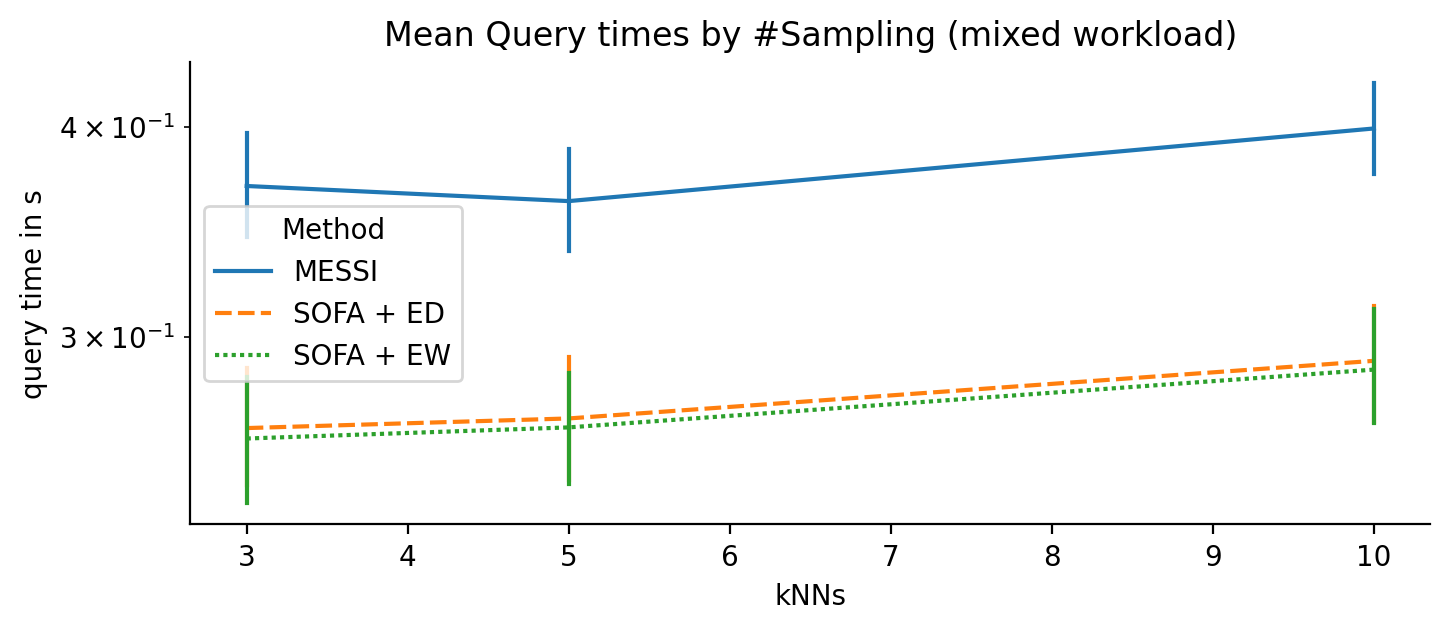

In [6]:
fig, ax = plt.subplots(figsize=(8,3))
sns.lineplot(x="kNNs", y="query time in s", hue="Method", estimator=np.mean,  err_style="bars", 
             style="Method", data=subset, ax = ax, errorbar=('ci', 99))
ax.set_title("Mean Query times by #Sampling (mixed workload)")
ax.set_xlabel("kNNs")
sns.despine()
ax.set_yscale("log")
plt.savefig("images/experiment_scalability_mean_knns.pdf", bbox_inches='tight')
plt.show()

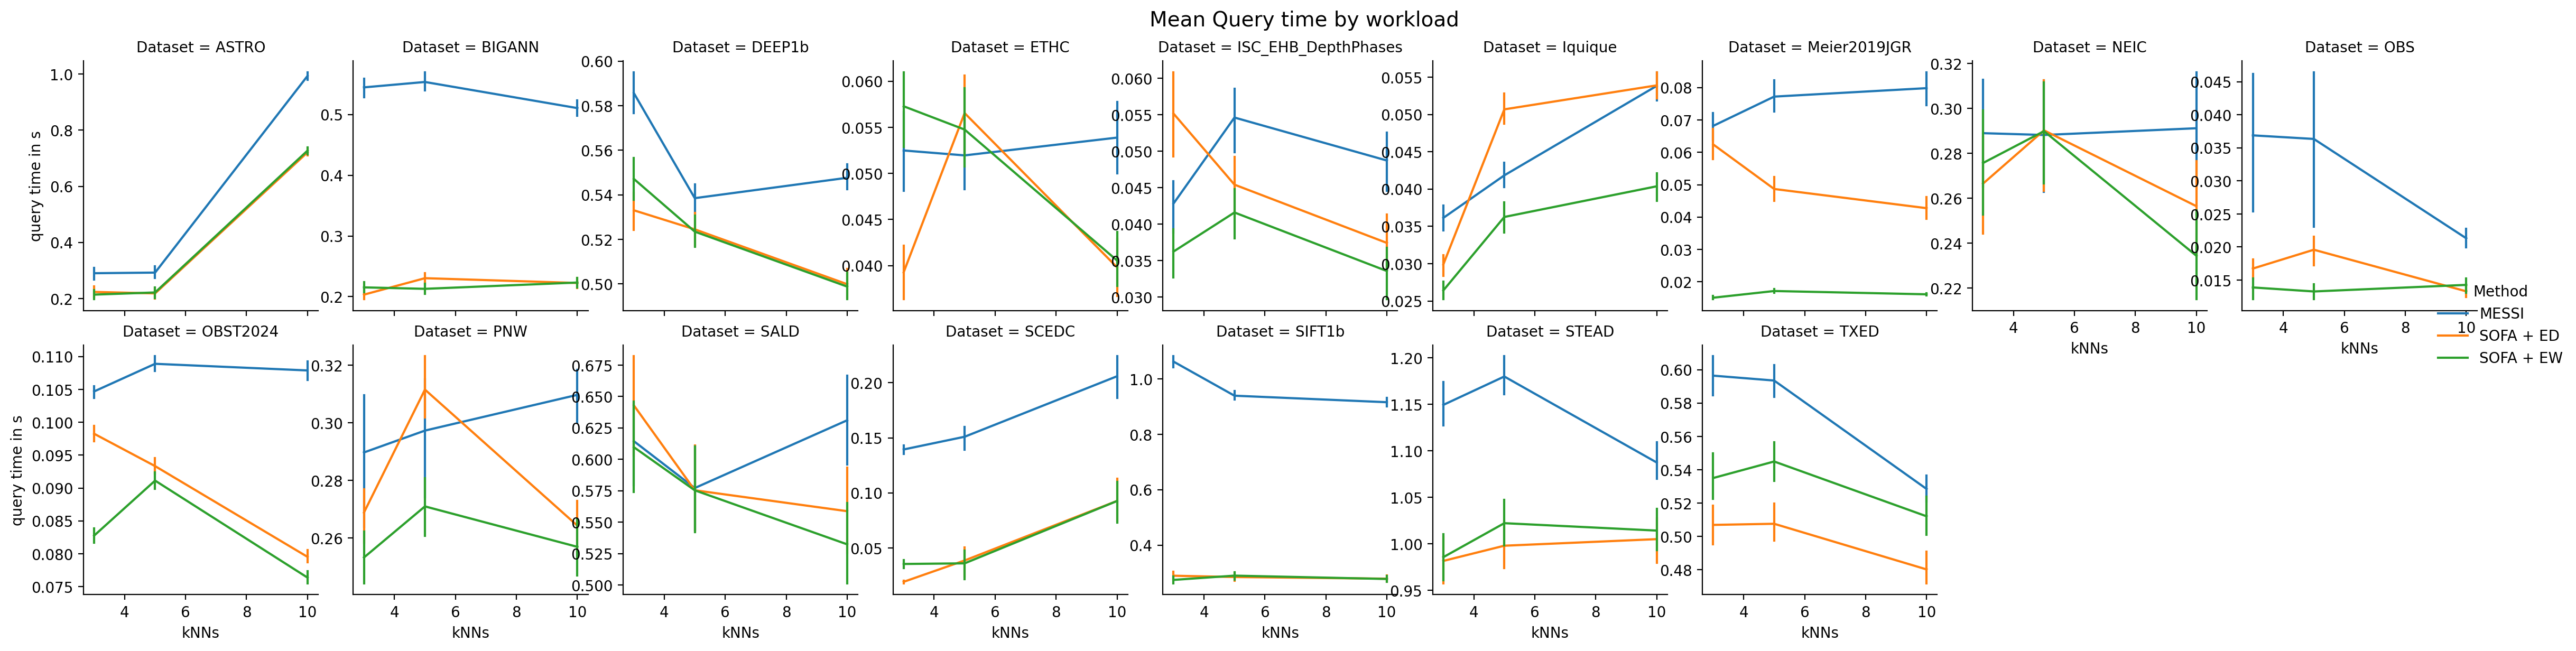

In [7]:
g = sns.relplot(x="kNNs", y="query time in s", hue="Method", estimator=np.mean,  
                err_style="bars", 
             col="Dataset", col_wrap=9, facet_kws={'sharey': False, 'sharex': True}, legend="brief",
             data=subset, kind="line", errorbar=('ci', 50))
g.fig.set_figwidth(24)
g.fig.set_figheight(6)
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Mean Query time by workload', size=14)
sns.despine()
plt.savefig("images/experiment_scalability_mean_all_kNNs.pdf", bbox_inches='tight')
plt.show()

<Axes: xlabel='kNNs', ylabel='query time in s'>

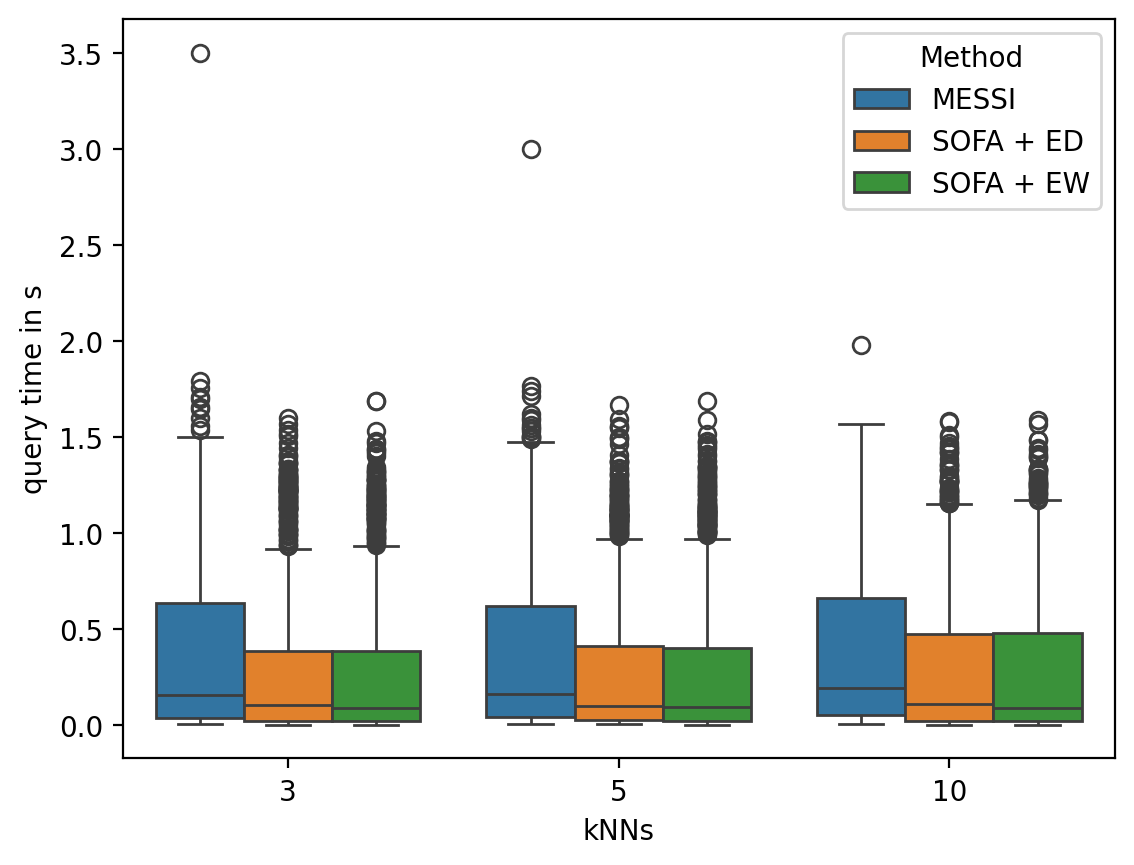

In [8]:
sns.boxplot(hue="Method", y="query time in s", x="kNNs", data=subset)

In [9]:
result_median = subset.groupby(["Method","kNNs"])["query time in s"].median().transform(lambda l: str(np.round(l * 1000))+" ms")
result_median

Method     kNNs
MESSI      3       156.0 ms
           5       160.0 ms
           10      194.0 ms
SOFA + ED  3       103.0 ms
           5       102.0 ms
           10      108.0 ms
SOFA + EW  3        90.0 ms
           5        97.0 ms
           10       92.0 ms
Name: query time in s, dtype: object

In [10]:
result_mean = subset.groupby(["Method","kNNs"])["query time in s"].mean().transform(lambda l: str(np.round(l * 1000))+" ms")
result_mean

Method     kNNs
MESSI      3       369.0 ms
           5       361.0 ms
           10      399.0 ms
SOFA + ED  3       265.0 ms
           5       268.0 ms
           10      290.0 ms
SOFA + EW  3       261.0 ms
           5       265.0 ms
           10      287.0 ms
Name: query time in s, dtype: object

In [11]:
result_all = pd.concat([result_median, result_mean], axis=1)
print(result_all.T.to_latex())

\begin{tabular}{llllllllll}
\toprule
Method & \multicolumn{3}{l}{MESSI} & \multicolumn{3}{l}{SOFA + ED} & \multicolumn{3}{l}{SOFA + EW} \\
kNNs &        3  &        5  &        10 &        3  &        5  &        10 &        3  &        5  &        10 \\
\midrule
query time in s &  156.0 ms &  160.0 ms &  194.0 ms &  103.0 ms &  102.0 ms &  108.0 ms &   90.0 ms &   97.0 ms &   92.0 ms \\
query time in s &  369.0 ms &  361.0 ms &  399.0 ms &  265.0 ms &  268.0 ms &  290.0 ms &  261.0 ms &  265.0 ms &  287.0 ms \\
\bottomrule
\end{tabular}



/var/folders/4l/py9g67fx10n68s69g0w8sghr0000gn/T/ipykernel_28546/585941613.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result_all.T.to_latex())
